In [58]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pygmt
import rioxarray as rio
import xarray as xr

In [ ]:
def

In [59]:
age = '120'

ocean = f'data/rasters/{age}Ma_nc_outputs/gold_spn_av_0000003000_00.nc'
oceanDS = xr.open_dataset(ocean)
oceanDS

atmos = f'data/rasters/{age}Ma_nc_outputs/3000-12-30_plasim.nc'
atmosDS = xr.open_dataset(atmos)
atmosDS

oceanDS = oceanDS.interp_like(atmosDS) #Re-cast the goldstein coordinates into the same as plasim

In [60]:
# Variables into xarray
# Goldstein
salinity = oceanDS['salinity'][0][0]
upwelling = oceanDS['wvel'][0][1]
# solarFlux = oceanDS['netsolar'][0]
runoff = oceanDS['runoff'][0]
bathymetry = oceanDS['bathymetry']

# Plasim

# To impose NaNs on land
landsea = atmosDS['grid_landsea_mask']
landseaNAN = xr.where(landsea>0.1, np.nan, 1)

surfaceTemp = atmosDS['puma_temperature_surface']*landseaNAN
SST_DJF = (atmosDS['DJF_GENIE_SST'] - 273.15)*landseaNAN
SST_JJA = (atmosDS['JJA_GENIE_SST'] - 273.15)*landseaNAN
solar = atmosDS['ebal_surface_solar_radiation']*landseaNAN
solar_DJF = atmosDS['DJF_incoming_solar']*landseaNAN
solar_JJA = atmosDS['JJA_incoming_solar']*landseaNAN

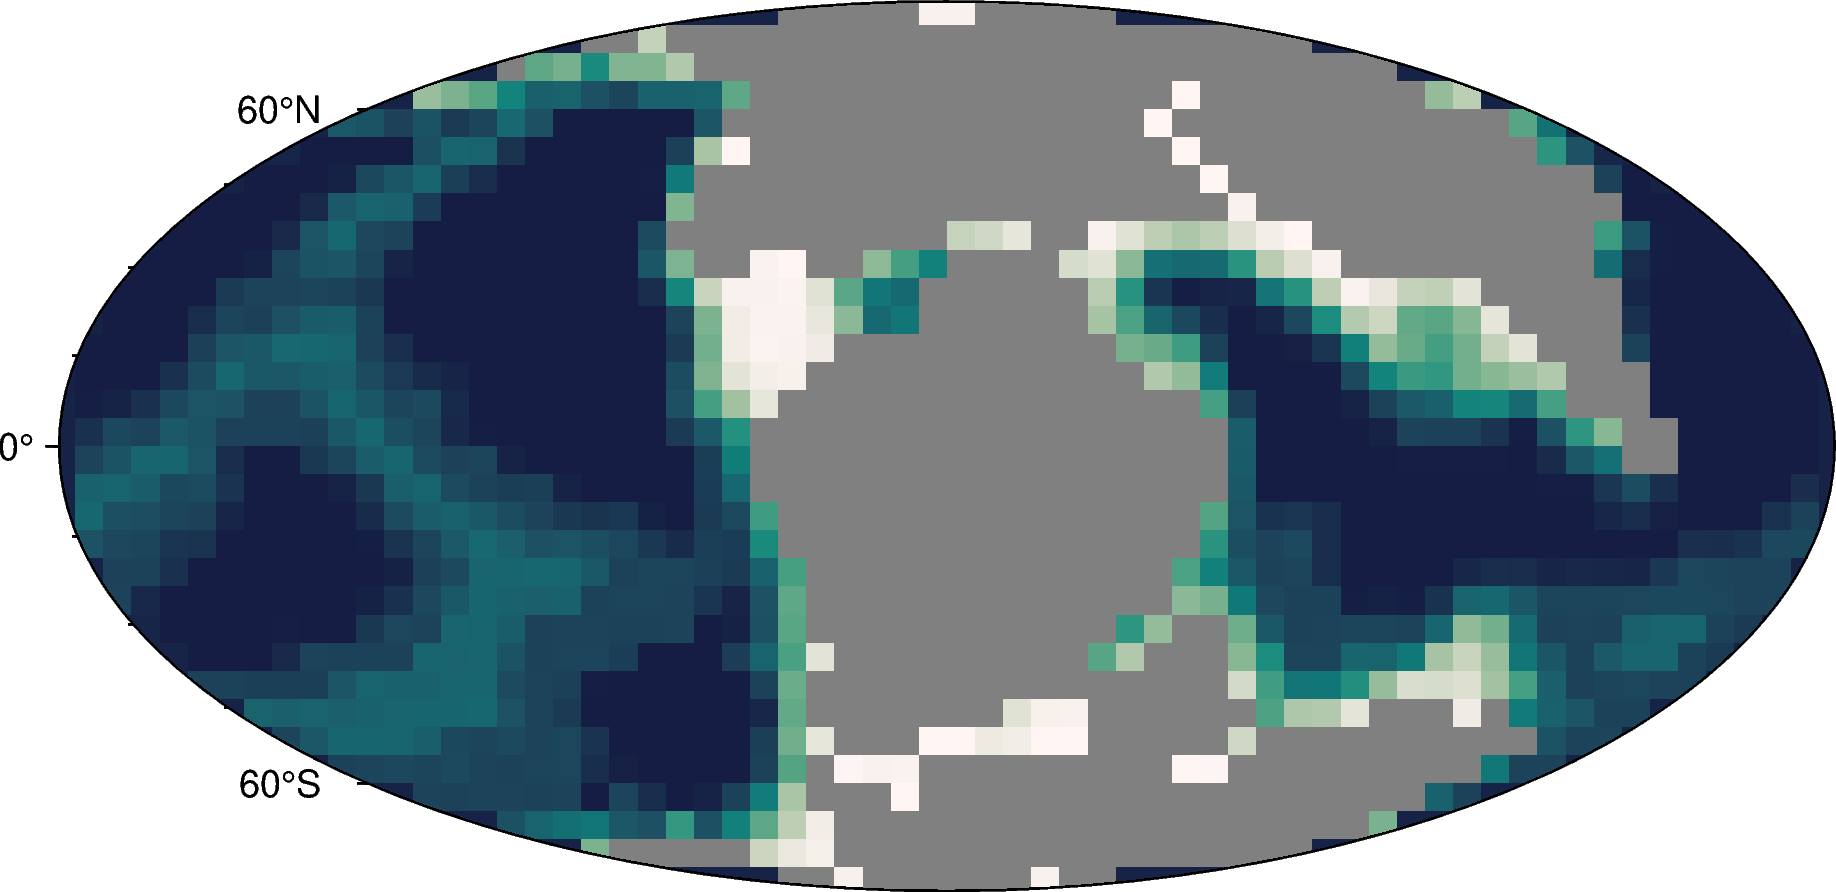

In [75]:
bathymetry
fig = pygmt.Figure()
fig.basemap(region="d", projection="W15c", frame=True)
fig.grdimage(bathymetry,cmap='tempo')
fig.show()

In [62]:
bathymetry

<xarray.DataArray 'bathymetry' (latitude: 32, longitude: 64)> Size: 8kB
array([[283.8467 , 283.8467 , 283.8467 , ..., 283.8467 , 283.8467 ,
        283.8467 ],
       [281.11533, 281.11533, 281.11533, ..., 281.11533, 281.11533,
        281.11533],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 256B 2.812 8.438 14.06 ... 345.9 351.6 357.2
  * latitude   (latitude) float32 128B 85.76 80.27 74.74 ... -80.27 -85.76
Attributes:
    long_name:  Ocean depth
    units:      m

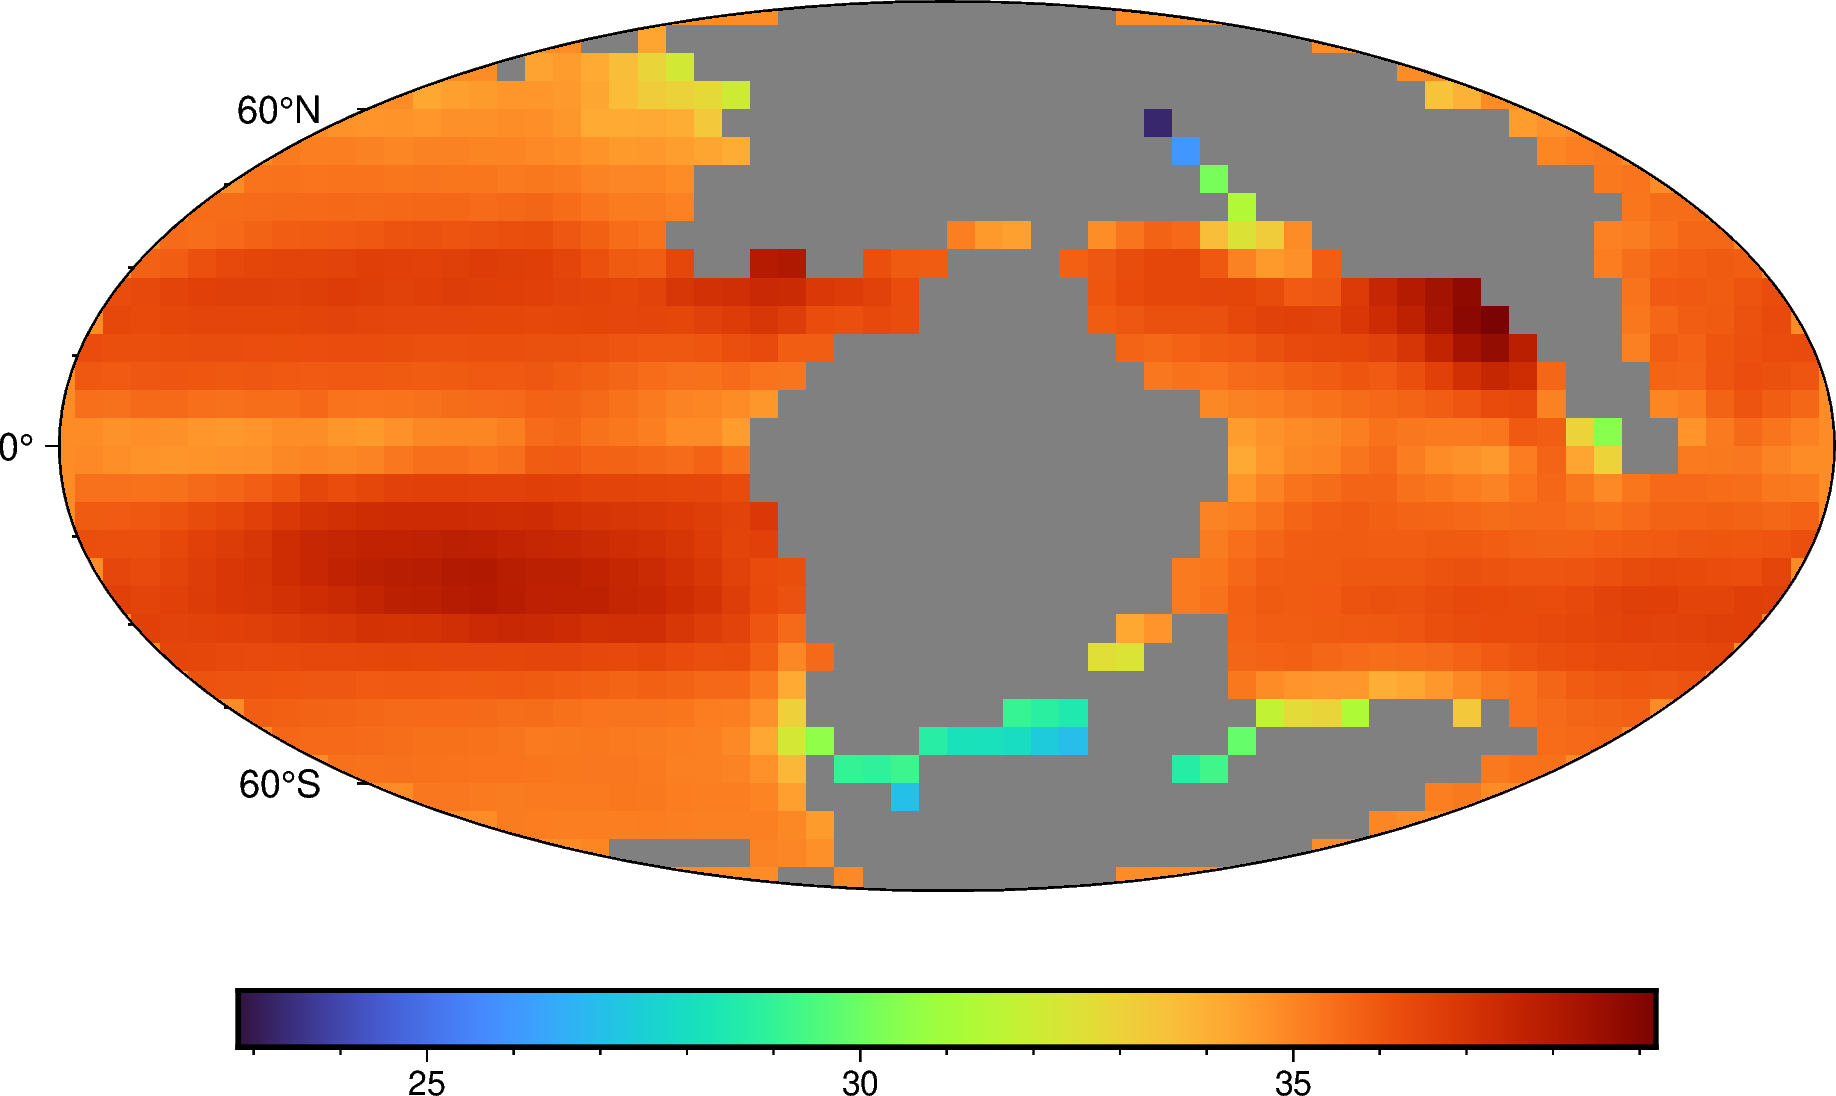

In [76]:
# Remove very low salinities
salinity = xr.where(salinity<22, np.nan, salinity)

fig = pygmt.Figure()
fig.basemap(region="d", projection="W15c", frame=True)
fig.grdimage(salinity)
fig.colorbar()
fig.show()

In [64]:
# Combine seasonal data to get summer and winter means
# SST
SST_DJF_northern = SST_DJF.where(SST_DJF.latitude<0,0)
SST_DJF_southern = SST_DJF.where(SST_DJF.latitude>0,0)

SST_JJA_northern = SST_JJA.where(SST_JJA.latitude<0,0)
SST_JJA_southern = SST_JJA.where(SST_JJA.latitude>0,0)

SST_summer = SST_DJF_northern + SST_JJA_southern
SST_winter = SST_DJF_southern + SST_JJA_northern

# Solar Insolation
solar_DJF_northern = solar_DJF.where(solar_DJF.latitude<0,0)
solar_DJF_southern = solar_DJF.where(solar_DJF.latitude>0,0)

solar_JJA_northern = solar_JJA.where(solar_JJA.latitude<0,0)
solar_JJA_southern = solar_JJA.where(solar_JJA.latitude>0,0)

solar_summer = solar_DJF_northern + solar_JJA_southern
solar_winter = solar_DJF_southern + solar_JJA_northern

In [65]:
# Check the difference between seasonal datasets
diff_SST = SST_summer - SST_winter

diff_solar = solar_summer - solar_winter

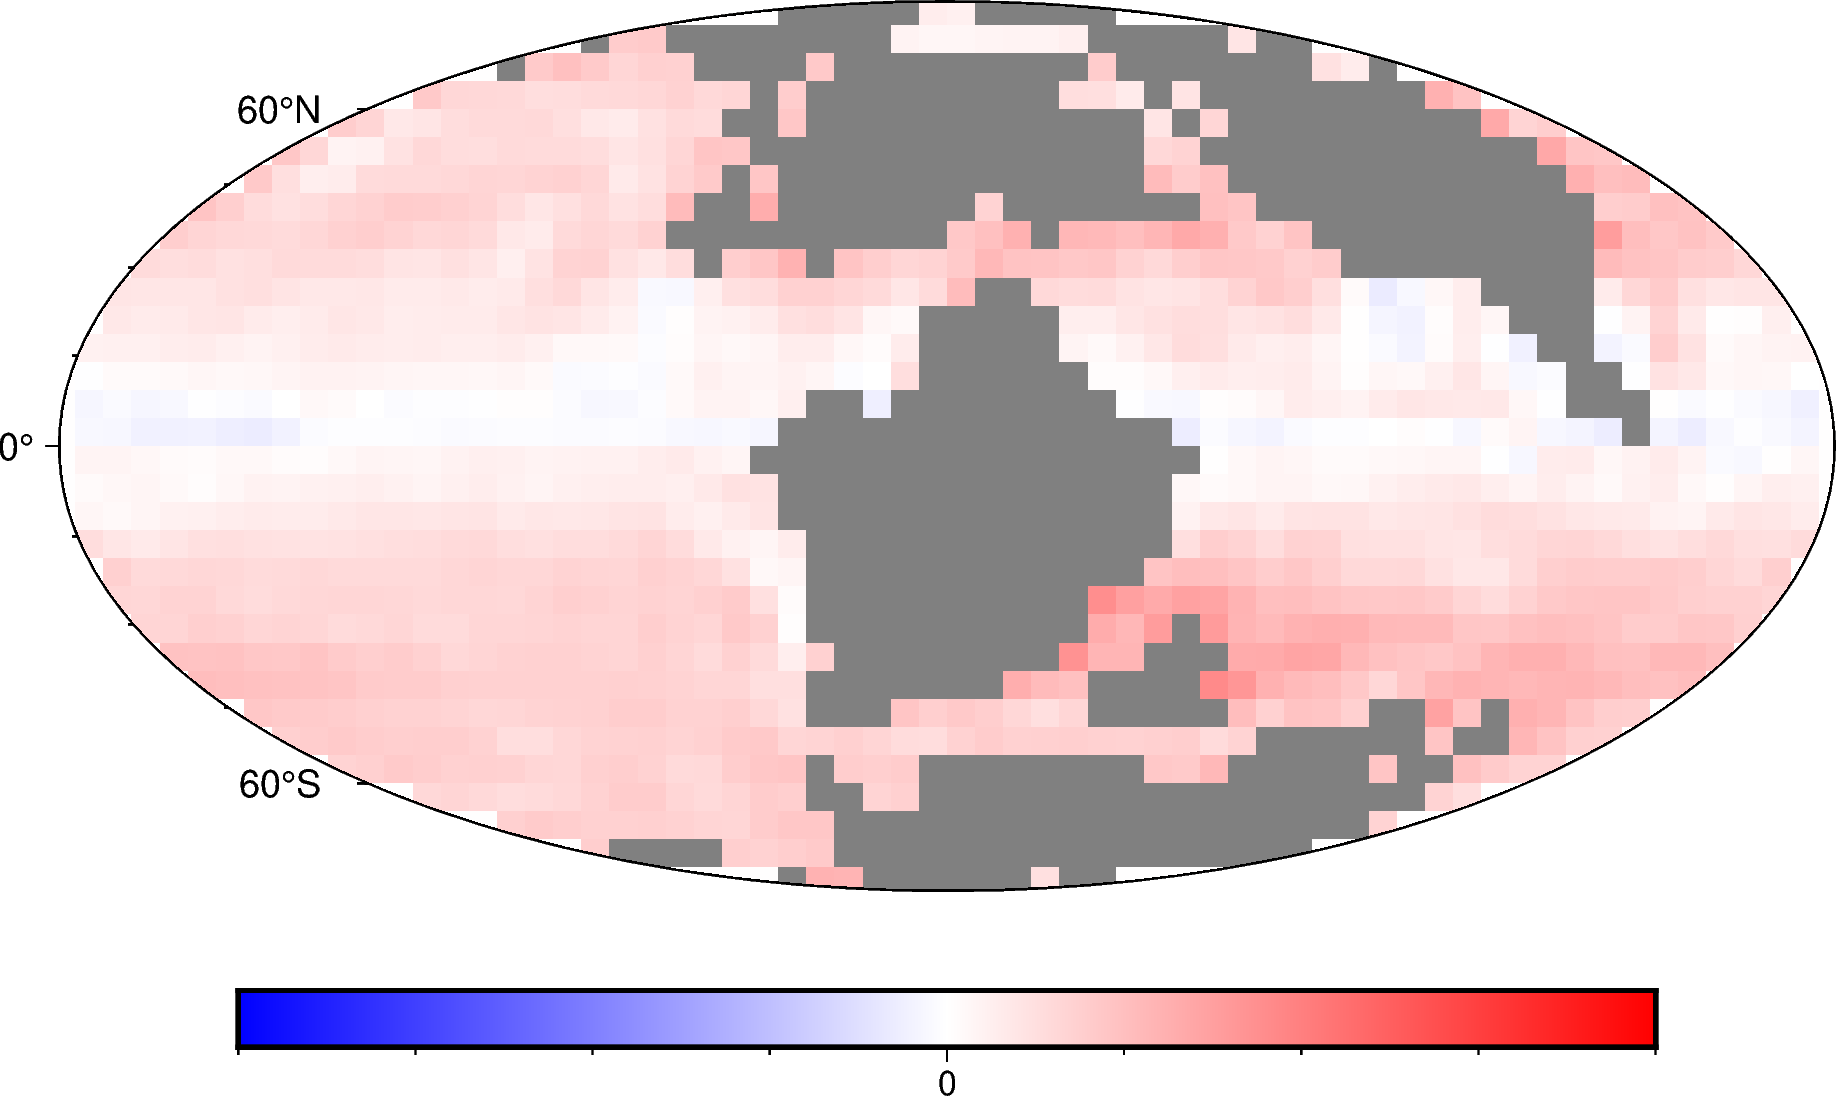

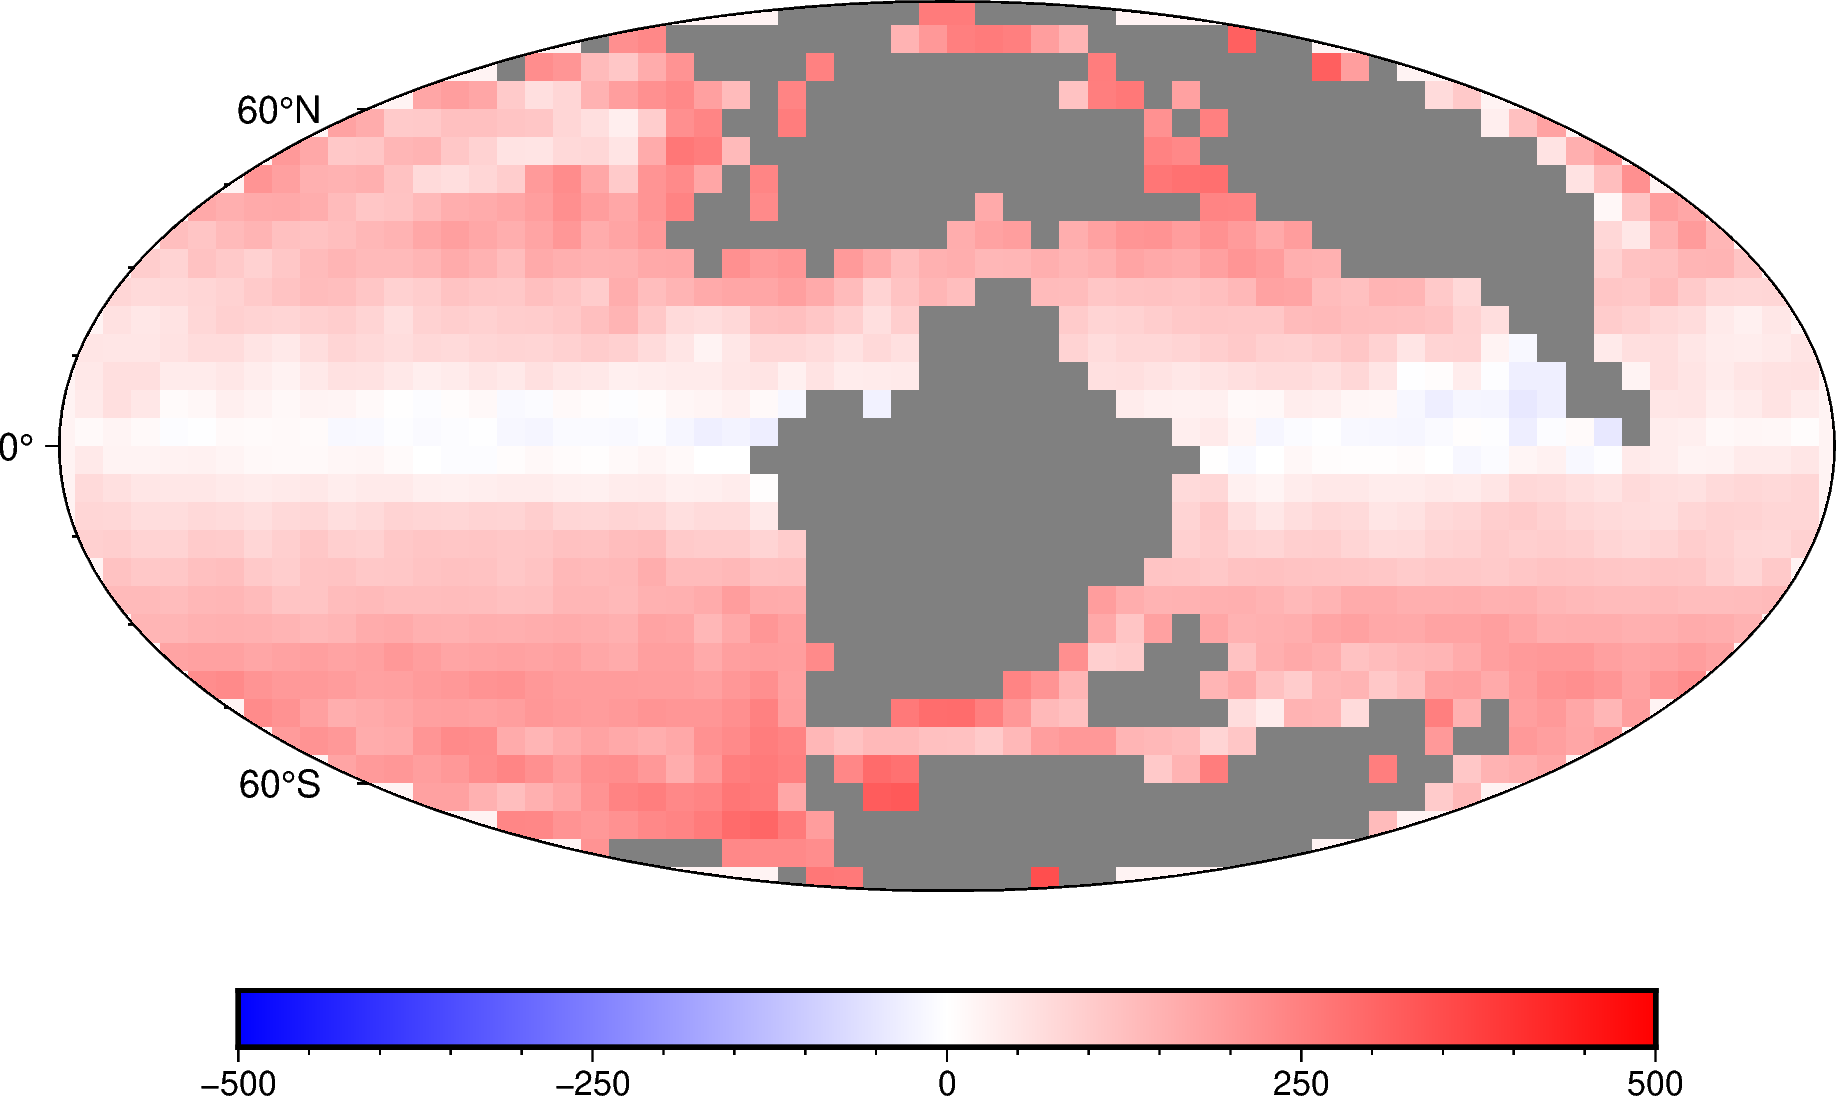

In [78]:
fig = pygmt.Figure()
cmap=pygmt.makecpt(cmap='polar', series=[-8,8])
fig.basemap(region="d", projection="W15c", frame=True)
fig.grdimage(diff_SST, cmap=cmap)
fig.colorbar(frame = 'a10f2', cmap=cmap)
fig.show()

fig = pygmt.Figure()
cmap=pygmt.makecpt(cmap='polar', series=[-500,500], background=True)
fig.basemap(region="d", projection="W15c", frame=True)
fig.grdimage(diff_solar, cmap=cmap)
fig.colorbar(frame = 'a250f50', cmap=cmap)
fig.show()

In [67]:
# Remove white space from meta data
# netsolar.attrs['long_name'] = 'netSolarHeatFlux'
bathymetry.attrs['long_name'] = 'oceanDepth'
upwelling.attrs['long_name'] = 'verticalCurrent'


In [68]:
# Convert to geoTiff
envRasterPath = f'data/rasters/{age}Ma_envRaster'
if not os.path.exists(envRasterPath):
    os.makedirs(envRasterPath)

surfaceTemp.rio.to_raster(f'{envRasterPath}/SST_annual.tif')
SST_summer.rio.to_raster(f'{envRasterPath}/SST_summer.tif')
SST_winter.rio.to_raster(f'{envRasterPath}/SST_winter.tif')

solar.rio.to_raster(f'{envRasterPath}/solar_annual.tif')
solar_summer.rio.to_raster(f'{envRasterPath}/solar_summer.tif')
solar_winter.rio.to_raster(f'{envRasterPath}/solar_winter.tif')

bathymetry.rio.to_raster(f'{envRasterPath}/bathymetry.tif')
salinity.rio.to_raster(f'{envRasterPath}/salinity_annual.tif')
upwelling.rio.to_raster(f'{envRasterPath}/upwelling_annual.tif')
runoff.rio.to_raster(f'{envRasterPath}/runoff_annual.tif')